In [1]:
### Imports

import os
import torch
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import RandomSampler, Sampler
from torchvision import transforms, utils
import torch.nn as nn

import tensorflow as tf
from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, TensorDataset, DataLoader
from typing import Iterator, Callable, List, Tuple
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm
import random
import collections

# PENTRU MODEL - TARAM TEODORA

In [2]:
bert_used = 'readerbench/RoBERT-base'

In [3]:
BATCH_SIZE = 8

In [4]:
USED_TYPE = 0
#### 0 for TITLE
#### 1 for CONTENT

In [5]:
MAX_TITLE_LEN = 180
MAX_CONTENT_LEN = 2048

In [6]:
import random


def reset_numpy_seed(seed_value=42):
  try:
    # Set NumPy random seed
    import numpy as np
    np.random.seed(seed_value)
    print(f'NumPy random seed set with value: {seed_value}')
  except Exception as e:
    print(f'NumPy random seed was not set: {e}')
  return


def reset_tensorflow_seed(seed_value=42):
  try:
    # Set TensorFlow random seed
    import tensorflow as tf
    success = False
    # Here we have 2 different ways to set the seed
    # depending on the version of TensorFlow
    try:
      tf.random.set_seed(seed_value)
      success = True
    except Exception as e:
      pass
    try:
      tf.set_random_seed(seed_value)
      success = True
    except Exception as e:
      pass
    if success:
      print(f'TensorFlow random seed set with value: {seed_value}')
    else:
      print(f'TensorFlow random seed was not set')
  except Exception as e:
    print(f'TensorFlow random seed was not set: {e}')
  return


def reset_torch_seed(seed_value=42):
  try:
    # Set PyTorch random seed
    import torch
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
      torch.cuda.manual_seed(seed_value)
      torch.cuda.manual_seed_all(seed_value)  # if you are using multiple GPUs
    print(f'PyTorch random seed set with value: {seed_value}')
  except Exception as e:
    print(f'PyTorch random seed was not set: {e}')
  return


def set_random_seeds(seed_value=42):
  # Set Python random seed
  random.seed(seed_value)
  reset_numpy_seed(seed_value)
  reset_tensorflow_seed(seed_value)
  reset_torch_seed(seed_value)
  return


if __name__ == '__main__':
  # Set the desired seed value
  seed = 7757

  # Set random seeds
  set_random_seeds(seed)

NumPy random seed set with value: 7757
TensorFlow random seed set with value: 7757
PyTorch random seed set with value: 7757


# GATA TARAM

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
read_data = pd.read_csv(
    "/content/drive/MyDrive/NLP3/train.csv")


In [9]:
print(read_data[read_data['class'] == False].shape)
print(read_data[read_data['class'] == True].shape)

(25307, 4)
(45268, 4)


In [ ]:
read_data["content"][41508]

Pregatirea datelor:
- Scoatem spatii multiple
- Url, email?
- greseli gramaticale?
- non-utf8
- procente?

In [10]:
X_train, X_test, y_train, y_test = train_test_split(read_data[['title', 'content']], read_data['class'], test_size=0.20)

df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [11]:
print(df_train.shape)
print(df_test.shape)

(56460, 3)
(14115, 3)


In [12]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cpu')
print("device = ", device)

device =  cpu


In [13]:
#Sursa: https://towardsdatascience.com/text-classification-with-bert-in-pytorch-887965e5820f
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(bert_used)

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [label for label in df['class']]
        self.titles = [tokenizer(str(text),
                                 padding='max_length', max_length = MAX_TITLE_LEN, truncation=True,
                                return_tensors="pt") for text in df['title']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_title(self, idx):
        # Fetch a batch of inputs
        return self.titles[idx]

    def __getitem__(self, idx):

        batch_title = self.get_batch_title(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_title, batch_y

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [14]:
train_dataset = Dataset(df_train) # 11 min

In [15]:
validation_dataset = Dataset(df_test)

In [16]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True)

In [17]:
val_dataloader = torch.utils.data.DataLoader(
    validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True)

In [24]:
from transformers import BertModel

class SatireClassifier(nn.Module):
    def __init__(self,
                 input_size: int,
                 hidden_size_1: int,
                 hidden_size_2: int,
                 hidden_size_3: int,
                 device: torch.device,
                 activation_fn: Callable,
                 dropout_rate: float):
        super(SatireClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_used)
        self.input_size = input_size
        self.hidden_size = hidden_size_1
        self.hidden_size_2 = hidden_size_2
        self.hidden_size_3 = hidden_size_3
        self.hidden_layer_1 = nn.Linear(768, 1)
        #self.hidden_layer_2 = nn.Linear(hidden_size_1, hidden_size_2)
        #self.hidden_layer_3 = nn.Linear(hidden_size_2, hidden_size_3)
        #self.output_layer = nn.Linear(hidden_size_2, 1) ####### Nu fi proasta si modifica
        self.activation_fn = activation_fn
        self.dropout = nn.Dropout(p=dropout_rate)
        self.device = device

    def forward(self, x, mask):
        #x = x.to(torch.float32)
        _, pooled_output = self.bert(input_ids= x, attention_mask=mask,return_dict=False)
        h1 = self.hidden_layer_1(pooled_output)
        #h2 = self.activation_fn(self.hidden_layer_2(h1))
        #h3 = self.activation_fn(self.hidden_layer_3(h2))
        #h = self.activation_fn(self.dropout(self.hidden_layer(x)))
        #out = self.output_layer(h2)

        return h1

In [19]:
def get_num_features():
  if USED_TYPE == 0:
    return MAX_TITLE_LEN
  else: return MAX_CONTENT_LEN

In [25]:
model = SatireClassifier(
    input_size=get_num_features,
    hidden_size_1=256,
    hidden_size_2=512,
    hidden_size_3=512,
    device=device,
    activation_fn=nn.ReLU(),
    dropout_rate=0.2
)
#model.to(device)
optimizer = optim.Adam(model.parameters(), lr=3e-4)

In [ ]:
for param in model. parameters ():
  print(param)

In [26]:
loss_crt = nn.BCEWithLogitsLoss(

)

In [ ]:
loss_crt = nn.CrossEntropyLoss()

In [ ]:
num_train_batches = len(train_dataloader)
num_val_batches = len(val_dataloader)

epoch_loss = 0.0
train_losses, val_losses = [], []
train_predictions, val_predictions = [], []
train_labels, val_labels = [], []
train_accuracies, val_accuracies = [], []

NUM_EPOCHS = 2

for epoch_idx in range(NUM_EPOCHS):
    train_labels = []
    val_labels = []
    train_preds = []
    val_preds = []

    train_epoch_loss = 0.0
    model.train()
    for batch_titles, batch_labels in tqdm(train_dataloader):
        model.zero_grad()

        batch_labels = batch_labels \
                  .type(torch.FloatTensor) \
                  .reshape((batch_labels.shape[0], 1)).to(device)

        mask = batch_titles['attention_mask'].to(device)
        input_id = batch_titles['input_ids'].squeeze(1).to(device)
        # feedforward
        out = model(input_id, mask)

        probabilities = torch.sigmoid(out.squeeze())  # Apply sigmoid activation
        batch_predictions = (probabilities >= 0.5).long()

        # compute loss
        loss = loss_crt(out, batch_labels)
        loss.backward()
        optimizer.step()
        train_epoch_loss += loss.item()
        train_labels += batch_labels.to(int).tolist()
        train_preds += batch_predictions.tolist()

    val_preds = []
    with torch.no_grad():
        model.eval()
        val_epoch_loss = 0.0
        for batch_titles, batch_labels in tqdm(val_dataloader):
            batch_labels = batch_labels \
                  .type(torch.FloatTensor) \
                  .reshape((batch_labels.shape[0], 1)).to(device)

            mask = batch_titles['attention_mask'].to(device)
            input_id = batch_titles['input_ids'].squeeze(1).to(device)
            # batch_size x 10
            # feedforward
            out = model(input_id, mask)
            probabilities = torch.sigmoid(out.squeeze())  # Apply sigmoid activation
            batch_predictions = (probabilities >= 0.5).long()

            # compute loss
            loss = loss_crt(out, batch_labels).item()
            val_epoch_loss += loss
            val_labels += batch_labels.to(int).tolist()
            val_preds += batch_predictions.tolist()

    train_epoch_loss /= num_train_batches
    val_epoch_loss /= num_val_batches
    train_acc = accuracy_score(train_labels, train_preds)
    valid_acc = accuracy_score(val_labels, val_preds)

    train_losses.append(train_epoch_loss)
    val_losses.append(val_epoch_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(valid_acc)

    print("epoch %d, train loss=%f, val loss=%f, train acc=%f, val acc=%f" % (
        epoch_idx, train_epoch_loss, val_epoch_loss, train_acc, valid_acc
    ))

  2%|▏         | 136/7058 [32:06<27:01:40, 14.06s/it]

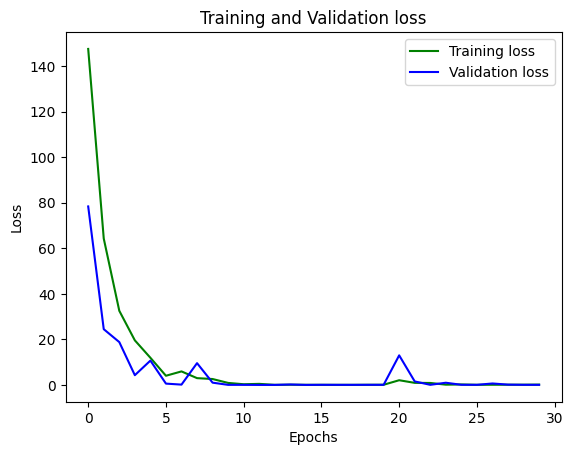

In [ ]:
%matplotlib inline
plt.plot(range(0,len(train_losses)), train_losses, 'g', label='Training loss')
plt.plot(range(0,len(train_losses)), val_losses, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

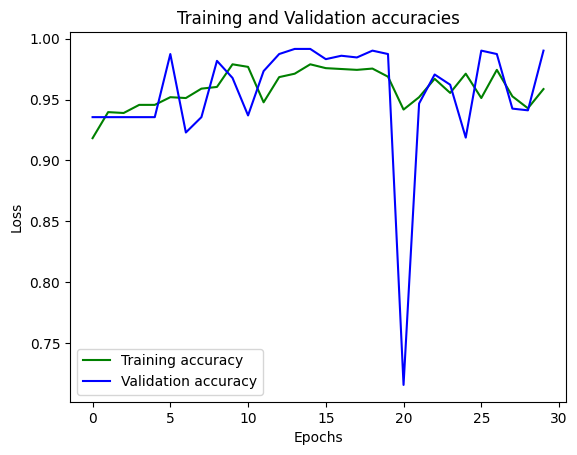

In [ ]:
plt.plot(range(0,len(train_accuracies)), train_accuracies, 'g', label='Training accuracy')
plt.plot(range(0,len(train_accuracies)), val_accuracies, 'b', label='Validation accuracy')
plt.title('Training and Validation accuracies')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def compute_confusion_matrix(predictions: List[int], labels:List[int]) -> Tuple[int]:
    """
    Compute the confusion matrix.
    Arguments:
        predictions: list of model predictions (0 for cats or 1 for dogs)
        labels: list of ground truth labels (0 or 1)
    """
    correct_cats = 0
    correct_dogs = 0
    wrong_cats = 0
    wrong_dogs = 0
    for (p,l) in zip(predictions, labels):
        if p == 0 and l == 0:
            correct_cats += 1
        elif p == 0 and l == 1:
            wrong_cats += 1
        elif p == 1 and l == 1:
            correct_dogs += 1
        else:
            wrong_dogs += 1

    return (correct_cats, wrong_cats, correct_dogs, wrong_dogs)

In [ ]:
def eval_epoch(model, val_dataloader, loss_crt, device):
    """
    model: Model object
    val_dataloader: DataLoader over the validation dataset
    loss_crt: loss function object
    device: torch.device('cpu) or torch.device('cuda')

    The function returns:
     - the epoch validation loss, which is an average over the individual batch
       losses
     - the predictions made by the model
     - the labels
    """
    model.eval()
    epoch_loss = 0.0
    num_batches = len(val_dataloader)
    predictions = []
    labels = []
    with torch.no_grad():
        for batch_titles, batch_content, batch_labels in tqdm(val_dataloader):
            batch_labels = batch_labels \
                  .type(torch.FloatTensor) \
                  .reshape((batch_labels.shape[0], 1))
            batch_labels = batch_labels.to(device)

            to_use = batch_content
            if USED_TYPE == 0:
              to_use = batch_titles

            mask = to_use['attention_mask'].to(device)
            input_id = to_use['input_ids'].squeeze(1).to(device)
            # batch_size x 10
            # feedforward
            out = model(input_id, mask)
            probabilities = torch.sigmoid(out.squeeze())  # Apply sigmoid activation
            batch_predictions = (probabilities >= 0.5).long()

            predictions += batch_predictions.squeeze().tolist()
            labels += batch_labels.squeeze().tolist()

            loss = loss_crt(out, batch_labels)
            loss_scalar = loss.item()

            epoch_loss += loss_scalar

    epoch_loss = epoch_loss/num_batches

    return epoch_loss, predictions, labels

In [ ]:
fin_loss, preds, labels = eval_epoch(
    model, val_dataloader, loss_crt, device)

90it [00:00, 1288.09it/s]


In [ ]:
len(preds)

714

357it [00:00, 1368.10it/s]


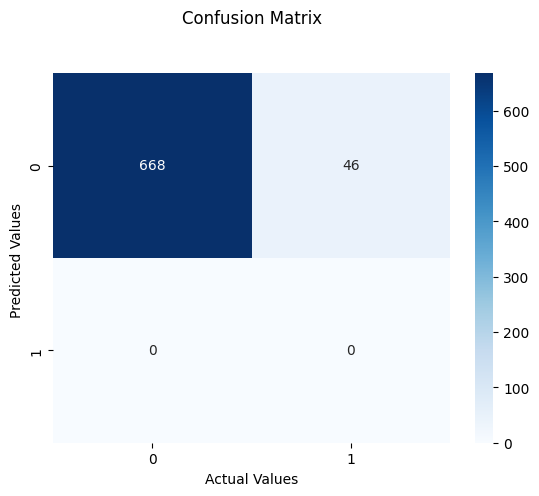

In [ ]:
fin_loss, preds, labels = eval_epoch(
    model, val_dataloader, loss_crt, device)


correct_cats, wrong_cats, correct_dogs, wrong_dogs = compute_confusion_matrix(
    preds,
    labels
)
cf_matrix = [
    [correct_cats, wrong_cats],
    [wrong_dogs, correct_dogs]
]
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['0','1'])
ax.yaxis.set_ticklabels(['0','1'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
len(preds)

180

In [ ]:
model1 = model

In [ ]:
fin_loss, val_predictions, val_labels = eval_epoch(
    model1, val_dataloader, loss_crt, device)

45it [00:00, 957.53it/s]


In [ ]:
model2 = model ##### overfit nebun, 512, 1024, 1025 ---//----

In [ ]:
model3 = model ###### 12 epoci, 256, 256, 256,      ...... , 20 376....

In [ ]:
print(torch.bincount(y_train))

tensor([2696,  156])
